In [1]:
using Pkg
pkg"activate ~/.julia/environments/v1.2"
pkg"resolve"
pkg"st"

Activating environment at `~/.julia/environments/v1.2/Project.toml`
 Resolving package versions...
  Updating `~/.julia/environments/v1.2/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.2/Manifest.toml`
 [no changes]
    Status `~/.julia/environments/v1.2/Project.toml`
  [fbb218c0] BSON v0.2.4
  [6e4b80f9] BenchmarkTools v0.4.3
  [3895d2a7] CUDAapi v2.0.0
  [c5f51814] CUDAdrv v4.0.4
  [be33ccc6] CUDAnative v2.5.5
  [3a865a2d] CuArrays v1.4.7 [`~/projects/CuArrays.jl`]
  [a93c6f00] DataFrames v0.19.4
  [ab46fb84] DensityRatioEstimation v0.2.1
  [163ba53b] DiffResults v0.0.4
  [31c24e10] Distributions v0.21.8
  [ced4e74d] DistributionsAD v0.1.1
  [26cc04aa] FiniteDifferences v0.9.0
  [587475ba] Flux v0.10.0
  [f6369f11] ForwardDiff v0.10.6
  [92c85e6c] GSL v0.6.0
  [7ec9b9c5] Humanize v1.0.0
  [7073ff75] IJulia v1.20.2
  [6218d12a] ImageMagick v0.7.5
  [c7f686f2] MCMCChains v0.3.15
  [eb30cadb] MLDatasets v0.4.0
  [519e820e] MLToolkit v0.3.0 [`~/projects/MLToolkit.jl`]
 

In [2]:
using Test, Distributed, PGFPlots, DataFrames
STYLE = (width = "10cm", height = "10cm")
addprocs(11)

┌ Info: Recompiling stale cache file /afs/inf.ed.ac.uk/user/s16/s1672897/.julia/compiled/v1.2/PGFPlots/XxINN.ji for PGFPlots [3b7a836e-365b-5785-a47d-02c71176b4aa]
└ @ Base loading.jl:1240


11-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12

In [8]:
@everywhere begin
    using AdvancedHMC, LinearAlgebra, MCMCChains
    using AdvancedHMC.Adaptation: NoAdaptation
    using Parameters: reconstruct
    using Statistics: mean, var, cov
    
    # Target distributions
    using Distributions: logpdf, MvNormal, InverseGamma, Normal
    using DiffResults: GradientResult, value, gradient
    using ForwardDiff: gradient!

    target1 = let D=30
        mu, sig = zeros(D), ones(D)
        # "with standard deviations of 110, 100, 1.1, 1.0, and 26 values equally spaced between 8 and 16"
        sig = [110, 100, 1.1, 1.0, range(8, 16; length=26)...]
        ℓπ(θ) = logpdf(MvNormal(mu, sig), θ)

        function ∂ℓπ∂θ(θ)
            res = GradientResult(θ)
            gradient!(res, ℓπ, θ)
            return (value(res), gradient(res))
        end
    
        (name="$(D)D Gaussian", D=D, ℓπ=ℓπ, ∂ℓπ∂θ=∂ℓπ∂θ)
    end

    target2 = let D=2
        function ℓπ(θ)
            s = exp(θ[1])
            m = θ[2]
            logprior = logpdf(InverseGamma(2, 3), s) + log(s) + logpdf(Normal(0, sqrt(s)), m) 
            loglikelihood = logpdf(Normal(m, sqrt(s)), 1.5) + logpdf(Normal(m, sqrt(s)), 2.0)
            return logprior + loglikelihood
        end

        function ∂ℓπ∂θ(θ)
            res = GradientResult(θ)
            gradient!(res, ℓπ, θ)
            return (value(res), gradient(res))
        end
        
        (name="Conjugate Gaussian", D=D, ℓπ=ℓπ, ∂ℓπ∂θ=∂ℓπ∂θ)
    end
end

In [13]:
target = target1

(name = "30D Gaussian", D = 30, ℓπ = getfield(Main, Symbol("#ℓπ#21")){Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Core.Box([110.0, 100.0, 1.1, 1.0, 8.0, 8.32, 8.64, 8.96, 9.28, 9.6  …  13.12, 13.44, 13.76, 14.08, 14.4, 14.72, 15.04, 15.36, 15.68, 16.0])), ∂ℓπ∂θ = getfield(Main, Symbol("#∂ℓπ∂θ#22")){getfield(Main, Symbol("#ℓπ#21")){Array{Float64,1}}}(getfield(Main, Symbol("#ℓπ#21")){Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Core.Box([110.0, 100.0, 1.1, 1.0, 8.0, 8.32, 8.64, 8.96, 9.28, 9.6  …  13.12, 13.44, 13.76, 14.08, 14.4, 14.72, 15.04, 15.36, 15.68, 16.0]))))

In [18]:
@everywhere function compute_metrics(samples, stats)
    val = hcat(samples...)'
    val = reshape(val, size(val)..., 1)
    chain = Chains(val)
    df = MCMCChains.describe(chain)[1].df
    ess = mean(df[!,:ess])
    mcse = mean(df[!,:mcse])
    n_steps_total = sum(map(t -> t.n_steps, stats))
    return (ess_ps=ess / n_steps_total, mcse=mcse)
end

function report!(container::AbstractArray, samples, stats; args=NamedTuple())
    ess_ps, mcse = compute_metrics(samples, stats)
    push!(container, (args..., ess_ps=ess_ps, mcse=mcse))
end

@everywhere function report!(container::RemoteChannel, samples, stats; args=NamedTuple())
    ess_ps, mcse = compute_metrics(samples, stats)
    put!(container, (args..., ess_ps=ess_ps, mcse=mcse))
end

n_samples = 12_000
n_adapts = 2_000
let n_runs=5
    results = RemoteChannel(() -> Channel(n_runs))
    @time @sync @distributed for _ in 1:n_runs
        let θ_init=rand(target.D),
            metric=DenseEuclideanMetric(target.D),
            h=Hamiltonian(metric, target.ℓπ, target.∂ℓπ∂θ),
            ϵ=find_good_eps(h, θ_init), 
            lf=Leapfrog(ϵ), 
            adaptor=StanHMCAdaptor(
                n_adapts,
                Preconditioner(metric),
                NesterovDualAveraging(0.8, lf.ϵ),
            )
            samples, stats = sample(h, NUTS{MultinomialTS,GeneralisedNoUTurn}(lf), θ_init, n_samples, adaptor, n_adapts; verbose=false, progress=false, drop_warmup=false)
            report!(results, samples[n_adapts+1:end], stats[n_adapts+1:end])
        end
    end
    close(results)
    # Fetch results
    results = [take!(results) for _ in 1:n_runs]
    # Show results
    ess_ps_list = map(t -> t.ess_ps, results) |> collect
    mcse_list = map(t -> t.mcse, results) |> collect
    @info "NUTS ($n_runs runs)" mean(ess_ps_list) var(ess_ps_list) mean(mcse_list) var(mcse_list)
end

 11.483538 seconds (186.64 k allocations: 9.296 MiB, 0.20% gc time)


┌ Info: NUTS (5 runs)
│   mean(ess_ps_list) = 0.2547592354914417
│   var(ess_ps_list) = 4.26882804522348e-5
│   mean(mcse_list) = 0.12396515884475738
│   var(mcse_list) = 9.546879091362936e-6
└ @ Main In[18]:47


In [14]:
arg_list = []

for ϵ in 0.1:0.1:1.6,
    n_steps in [1, 2, 4, 8],
    α in 0.1:0.1:1.0
    push!(arg_list, (name=target.name, ϵ=ϵ, n_steps=n_steps, α=α))
end

metric = UnitEuclideanMetric(target.D)
h = Hamiltonian(metric, target.ℓπ, target.∂ℓπ∂θ)
adaptor = NoAdaptation()

n_exps = length(arg_list)
println("Generated $n_exps experiment settings.")

Generated 640 experiment settings.


In [15]:
results = RemoteChannel(() -> Channel(n_exps))

println("Running $n_exps experiments ...")
@time @sync @distributed for args in arg_list
    samples, stats = sample(h,  HMC{MultinomialTS}(Leapfrog(args.ϵ), args.n_steps) , rand(target.D), n_samples, adaptor, n_adapts; α=args.α, verbose=false, progress=false, drop_warmup=false)
    # Report results
    report!(results, samples[n_adapts+1:end], stats[n_adapts+1:end]; args=args)
end

close(results)

results = [take!(results) for _ in 1:n_exps]

;

Running 640 experiments ...
175.625423 seconds (314.53 k allocations: 13.455 MiB)


In [16]:
df = DataFrame()
for r in results
    push!(df, map(x -> x isa Number && isnan(x) ? 0 : x, r))
end

;

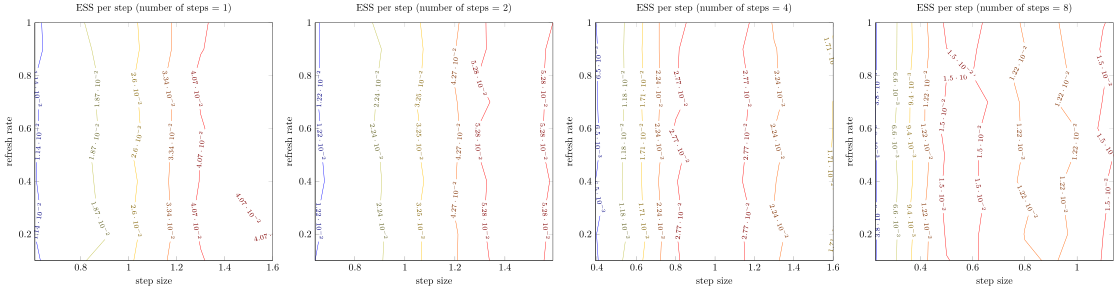

In [17]:
gp = GroupPlot(4, 1, groupStyle = "horizontal sep = 1.5cm, vertical sep = 2.0cm")

idx_sym = :n_steps
idx = (val=sort(unique(df[!, idx_sym])), name="number of steps")
for idx_val in idx.val
    let df=df[df[!,idx_sym] .== idx_val,:]
        x_sym = :ϵ
        x = (val=sort(unique(df[!, x_sym])), name="step size")
        y_sym = :α
        y = (val=sort(unique(df[!, y_sym])), name="refresh rate")
        z = Matrix{Float64}(undef, length(x.val), length(y.val))
        for (i, xi) in enumerate(x.val), 
            (j, yj) in enumerate(y.val)
            _df = df[df[!, x_sym] .≈ xi,:]
            z[i,j] = _df[_df[!, y_sym] .≈ yj,:].ess_ps[]
        end

        push!(gp, Axis(Plots.Contour(z, x.val, y.val); xlabel=x.name, ylabel=y.name, title="ESS per step ($(idx.name) = $idx_val)", STYLE...))
    end
end

gp

In [ ]:
# for (metricstr, metric) in Dict(
#         "Unit" => UnitEuclideanMetric(D),
# #         "Diag" => DiagEuclideanMetric(D),
# #         "Dense" => DenseEuclideanMetric(D),
#     )
#     h = Hamiltonian(metric, ℓπ, ∂ℓπ∂θ)
#     for (lfstr, lf) in Dict(
#             ("Leapfrog" => Leapfrog(ϵ) for ϵ in [0.1, 0.2, 0.4, 0.8])...,
# #             "JitteredLeapfrog" => JitteredLeapfrog(ϵ, 1.0),
# #             "TemperedLeapfrog" => TemperedLeapfrog(ϵ, 1.05),
#         )
#         for (τstr, τ) in Dict(
# #             ("HMC{LastTS}($n_steps)" => HMC{LastTS}(lf, n_steps) for n_steps in [1, 5, 10])...,
#             ("HMC{MultinomialTS}" => HMC{MultinomialTS}(lf, n_steps) for n_steps in [1, 5, 10, 15, 20])...,
# #             "NUTS{MultinomialTS,Generalised}" => NUTS{MultinomialTS,GeneralisedNoUTurn}(lf),
#         ) 
#             for (adaptorstr, adaptor) in Dict(
#             "NoAdaptation" => NoAdaptation(),
# #             "PreconditionerOnly" => Preconditioner(metric),
# #             "NesterovDualAveragingOnly" => NesterovDualAveraging(0.8, τ.integrator.ϵ),
# #             "NaiveHMCAdaptor" => NaiveHMCAdaptor(
# #                 Preconditioner(metric),
# #                 NesterovDualAveraging(0.8, τ.integrator.ϵ),
# #             ),
# #             "StanHMCAdaptor" => StanHMCAdaptor(
# #                 n_adapts,
# #                 Preconditioner(metric),
# #                 NesterovDualAveraging(0.8, τ.integrator.ϵ),
# #             ),
#                 )
#                 for α in 0.1:0.1:1.0
#                     # For `Preconditioner`, we use the pre-defined step size as the method cannot adapt the step size.
#                     # For other adapatation methods that are able to adpat the step size, we use `find_good_eps`.
#                     push!(exp_settings, (metricstr, lfstr, τstr, adaptorstr, metric, h, lf, τ, adaptor, α))
#                 end
#             end
#         end
#     end
# end

In [94]:
for r in [r"HMC{Last", r"HMC{Multi", r"NUTS"]
    df_sub = df[[occursin(r, s) for s in df.τ], :]
    println(df_sub[findmax(df_sub.ess_ps)[2], :])
end

ArgumentError: ArgumentError: collection must be non-empty